# Improving the evaluation of a stereo matching network 

In August 2018 I finished my master thesis: "[Height Estimation from Aerial Imagery with Stereo Matching Networks](http://www.scriptiesonline.uba.uva.nl/cgi/b/bib/bib-idx?type=simple;lang=en;c=uvascript;sid=8373f4538f03cefded2abaaf3e0aa4d0;rgn1=entire%20record;q1=j.c.%20zuurmond;Submit.x=0;Submit.y=0;sort=publicationyear;cc=uvascript;view=reslist;fmt=long;page=reslist;start=1;size=1)". I conducted a comparitive study of the accuracy in height estimation of two stereo mathing networks benchmarked againstsemi-global matching.

The best performing method is the network architecture proposed by J.R Chang and Y.S. Cheng in their ["Pyramid stereo matching (PSM) networks"  paper](https://arxiv.org/abs/1803.08669). It was originally applied to the KITTI dataset, a dataset with stereo images taken from a car. I applied their model to a different domain, namely to overhead imagery instead of images with a frontal perspective (see figures below).

Now, half a year later, I look back at my thesis and see what I could have done better. In this notebook I will show how I would improve the evaluation of this stereo mathing network.

I will explain the application my thesis a little more and how the models are evaluated. For a more detailed explanation see my [thesis](http://www.scriptiesonline.uba.uva.nl/cgi/b/bib/bib-idx?type=simple;lang=en;c=uvascript;sid=8373f4538f03cefded2abaaf3e0aa4d0;rgn1=entire%20record;q1=j.c.%20zuurmond;Submit.x=0;Submit.y=0;sort=publicationyear;cc=uvascript;view=reslist;fmt=long;page=reslist;start=1;size=1). For those who are interested, in my thesis I proposed an extension to the PSM network.

# What is stereo mathing? 

In stereo matching, pixels in a reference (left) image are matched with pixels in a target (right) image in order to estimate depth. It is comparable with how we - living beings - see depth with our eyes. See the picture below.

![stereo vision frontal imagery](figures/stereo_vision.png)

If the pixels that correspond with a point visible in both (orthorectified) images are known, for example the point in the top left corner of the cube, then the depth can be evaluated using the geometrics of the camera system. 

In pixel space the shift in pixels between the two images is known as disparity $d_i$. The disparity can be translated too depth, using the camera intrinsics and camera system geomatrics. How bigger the disparity is, how closer the point is to the camera.

This picture shows the set-up for frontal images - for example taken from a car. In my thesis I did the same, but then the images are taken from an airplane, see picture below.

![stereo vision overhead imagery](figures/overhead_martijn.png)

The concept is exactly the same. The left and right images are capture when the plane flies twice over the same area. The depth can be translated to height using the (flight) height at which the pictures are captured.

A crucial part of stereo matching is matching pixels in the reference images with the pixels in the target images. This is done by the stereo matching network.

# Evaluation

In my thesis I used the same evaluation metric which is used for the KITTI benchmark dataset, namely the relative n-pixel error. The n-pixel error is defined as:

$$ || d_i - \hat{d_i} || > n $$

Where $ d_i $ is the ground-truth disparity, obtained with radar (LIDAR), and $\hat{d_i}$ the estimated disparity.

So, the 1-pixel error, is the number of pixels for which the absolute difference between the ground-truth and estimated disparity is more than one pixel. Finally this number is dived by the total of number of pixels $N$ to get the relative 1-pixel error.

In [1]:
import glob
import os

import numpy as np
import pandas as pd


def load_observations(data_dir):
    all_files = sorted(glob.glob(os.path.join(data_dir, '*.npy')))
    benchmark_images = (np.load(f) for f in all_files if f.endswith('_b.npy'))
    ground_truth_images = (np.load(f) for f in all_files if f.endswith('_d.npy'))
    
    benchmark, ground_truth = np.array([]), np.array([])
    for bench, gt in zip(benchmark_images, ground_truth_images):
        mask = (
              (~np.isnan(bench)) # benchmark is a sparse pixel map
            & (~np.isnan(gt))    # there might be some erroneous pixels
            & (gt <= 192)      # maximum disparity is 192
            & (gt > 0)         # minimum disparity is 0
        )
        benchmark = np.append(benchmark, bench[mask])
        ground_truth = np.append(ground_truth, gt[mask])
    return pd.DataFrame(
        {'benchmark': benchmark,
         'ground_truth': ground_truth}
    )
    
observations = load_observations('../data/')
print(f'There are {observations.shape[0] / 1e6:.2} million observations')
observations.head()

There are 4.6 million observations


benchmark  ground_truth
0       12.0     11.867012
1       12.0     11.867012
2       12.0     11.885419
3       12.0     11.885419
4       12.0     11.820505

In [2]:
def _n_pixel_error(d, d_hat, n=1):
    return np.average(np.abs(d - d_hat) > n)


def n_pixel_error(df, col, n=1):
    return _n_pixel_error(
        df['ground_truth'].values, 
        df[col].values,
        n=n
    )

error = n_pixel_error(observations, col='benchmark')

print(f'The benchmark has a 1-pixel error of {error:.3}')

The benchmark has a 1-pixel error of 0.0321


In [3]:
# Some other stats
abs_diff = np.abs(observations['ground_truth'].values - observations['benchmark'].values)

print(f'Mean absolute difference is \t: {np.mean(abs_diff):.4}')
print(f'Median absolute difference is \t: {np.median(abs_diff):.4}')
print(f'Maximum absolute difference is \t: {np.max(abs_diff):.4}')

Mean absolute difference is 	: 0.8309
Median absolute difference is 	: 0.1968
Maximum absolute difference is 	: 189.9


In [4]:
# Note: there are some extreme outliers.
print(f'95 percentile absolute difference is \t: {np.percentile(abs_diff, 95):.4}')
print(f'98 percentile absolute difference is \t: {np.percentile(abs_diff, 98):.4}')
print(f'99 percentile absolute difference is \t: {np.percentile(abs_diff, 99):.4}')

95 percentile absolute difference is 	: 0.723
98 percentile absolute difference is 	: 4.351
99 percentile absolute difference is 	: 17.96


In [5]:
frac = np.sum(abs_diff < 5) / len(abs_diff)
print(f'{frac * 100:.3}% of the pixels have an absolute difference of 5 or less')

frac = np.sum(abs_diff < 10) / len(abs_diff)
print(f'{frac * 100:.3}% of the pixels have an absolute difference of 10 or less')

frac = np.sum(abs_diff < 20) / len(abs_diff)
print(f'{frac * 100:.3}% of the pixels have an absolute difference of 20 or less')

98.1% of the pixels have an absolute difference of 5 or less
98.6% of the pixels have an absolute difference of 10 or less
99.1% of the pixels have an absolute difference of 20 or less


# Improving the evaluation

I have three proposals to improve the evaluation:

1. Add uncertainty to the 1-pixel error. The given values do not say much without uncertainties. Actually we are only interested in the upper limited, not the lower limited.
1. Calculate uncertainty of the estimated disparities. In the end we are not interested too much in the 1-pixel errors, we are more interested in the accuracy of the disparities (or actually heights).
2. Zoom-in on pixels which are likely to be at an object edge, i.e. pixels which are in proximity of a jump in disparity. For example the pixels that correspond with the edge of a roof.

_The last needs some extra motivation:_

The company I did my thesis at, Readar, uses the depth information to (more accurately) extract roof segments from the aerial imagery. These segments are for example used to check if it is an asbestos roof or not.

When extracting these segments the pixels at the edge of a roof are most important to get right. If the pixels in the middle of the roof have an inaccrate disparity, that is not too much of a problem. If you are accurate for pixels at the edge of a roof, you could use those to extract a rectangular plane, because most roofs are rectangular planes. 

For this reason it is most important to be accurate for the pixels at the edge of a roof.

# Error margin of the 1-pixel error

This error margin can be calculated with bootstrapping.

In [6]:
from tqdm import tqdm_notebook as tqdm

n, n_samples = 1, int(1e6)
errors = []
for i in tqdm(range(1000)):
    errors.append(n_pixel_error(
        observations.sample(n_samples), 'benchmark', n=n))
    
print(f'Upper bound is: {np.percentile(errors, 99):.4}')


Upper bound is: 0.03243


The upper bound is only slighlty more then the actuall 1-pixel error! So (luckily) it does not matter much that this upper bound was not included in my thesis.

# Error margin of the disparity


This error margin is calculated with pymc3. We assume the following relationship:

$$
d \sim \mathcal{N}(\hat{d}, \sigma)
$$

In [7]:
import pymc3 as pm

def run(df):
    with pm.Model():
        # Prior for the standard deviation on the disparity
        sigma = pm.HalfCauchy('sigma', beta=1)

        ground_truth_disparity = pm.Normal(
            'd', 
            mu=df.benchmark.values, 
            sd=sigma, 
            observed=df.ground_truth.values
        )

        trace = pm.sample(njobs=6, tune=1000, draws=1500, chains=1)
    return trace


# There are some outliers, which offset the sigma a lot
# theser are filtered out. Some outliers might occure due to erroneous
# ground-truth measurements.
observations_filtered = (
    observations
    .assign(abs_diff=lambda df: np.abs(df['ground_truth'] - df['benchmark']))
    .loc[lambda df: df['abs_diff'] <= 20]
)

print(f'There are {observations_filtered.shape[0]} filtered observations')

trace = run(observations_filtered.sample(int(1e6)))

There are 4585608 filtered observations


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma]
100%|██████████| 2500/2500 [00:45<00:00, 54.47it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


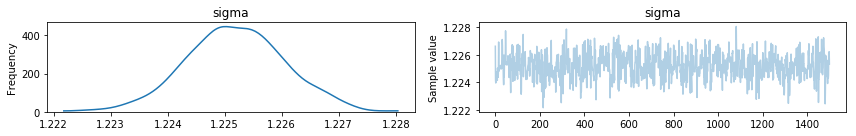

In [8]:
_ = pm.traceplot(trace)

Here we see that the standard deviation on the disparity is around __1.2__. The pixels with large absolute difference have a lot of influence on this error margin.